In [1]:
import numpy as np

from sklearn import datasets
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

# 1. PCA 

In [2]:
class My_PCA:
    
    def __init__(self, n_component):
        '''
        Parameters:
        -----------
        n_component: int, float
            Number of components to keep
            if n_component > 1, n_component principle components are kept.
            
            if 0 < n_component < 1, select the number of components such that the 
            amount of variance that needs to be explained is greater than the percentage 
            specified by n_components.
        '''
        self.n_component = n_component
        self.components = None
        self.mean = None
        
        self.dims = None
    
    def __explained_variance_gt(self, E, percentage):
        '''
        select the number of components such that the 
        amount of variance that needs to be explained is greater than the percentage 
        specified by n_components.
        
        Parameters:
        -----------
        E: array-like, shape (dims,)
            diagnal matrix containing eigenvalues
        
        Returns:
        --------
        num: int
            Returns the number of components. 
        '''
        explained_variance = (E ** 2) 
        total_var = np.sum(explained_variance)
        explained_variance_ratio = explained_variance / total_var
        ratio_cumsum = np.cumsum(explained_variance_ratio)
        num = np.searchsorted(ratio_cumsum, percentage) + 1
        
        return num
        
    
    def fit(self, X):
        '''
        Step 1: the input data X is centered. 
        Step 2: compute SVD of X
        Step 3: select the number of components
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        
        Returns:
        --------
        self: Object
            Returns the instance itself.
        '''
        
        self.dims = X.shape[1]
        
        '''
        step 1: 
        center X.
        '''
        self.mean = np.mean(X, axis=0)
        X = X - self.mean
        
        '''
        step 2:
        compute SVD of X and keep the eigenvectors of right singular matrix which is 
        exactly the eigenvectors of covariance matrix X^T*X
        '''        
        U, E, VT = np.linalg.svd(X)
    
        '''
        step 3: determine the number of eigenvectors         
        '''
        if self.n_component < 1:            
            num = self.__explained_variance_gt(E, self.n_component)
        else:
            num = self.n_component
            
        self.components = VT[:num, :]
        
        return self
        
    
    def transform(self, X):
        
        assert X.shape[1] == self.dims, "Shape(%d, %d) of X doesn't match the dimenstions %d" % (X.shape[0], X.shape[1], self.dims)
        
        X = X - self.mean
        X_ = np.matmul(X, self.components.T)
        
        return X_
    

# 2. Comparison between sklearn.PCA and my PC.

* In the source code of sklearn.PCA, it executes the function svd_flip() to correct the signs. That's why the sign of some columns is the opposite of my result. In fact, I have no idea about the motivation of svd_flip().

In [15]:
%%time

iris = datasets.load_iris()
X = iris.data

# X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
pca = PCA(n_components=3)
pca.fit(X)
X = pca.transform(X)

print('show the first 10 rows:\n', X[:10])

show the first 10 rows:
 [[-2.68412563  0.31939725 -0.02791483]
 [-2.71414169 -0.17700123 -0.21046427]
 [-2.88899057 -0.14494943  0.01790026]
 [-2.74534286 -0.31829898  0.03155937]
 [-2.72871654  0.32675451  0.09007924]
 [-2.28085963  0.74133045  0.16867766]
 [-2.82053775 -0.08946138  0.25789216]
 [-2.62614497  0.16338496 -0.02187932]
 [-2.88638273 -0.57831175  0.02075957]
 [-2.6727558  -0.11377425 -0.19763272]]
CPU times: user 4.06 ms, sys: 2.31 ms, total: 6.37 ms
Wall time: 6.67 ms


In [16]:
%%time
iris = datasets.load_iris()
X = iris.data

pca = My_PCA(3)
pca.fit(X)
X = pca.transform(X)

print('show the first 10 rows:\n', X[:10])

show the first 10 rows:
 [[-2.68412563 -0.31939725  0.02791483]
 [-2.71414169  0.17700123  0.21046427]
 [-2.88899057  0.14494943 -0.01790026]
 [-2.74534286  0.31829898 -0.03155937]
 [-2.72871654 -0.32675451 -0.09007924]
 [-2.28085963 -0.74133045 -0.16867766]
 [-2.82053775  0.08946138 -0.25789216]
 [-2.62614497 -0.16338496  0.02187932]
 [-2.88638273  0.57831175 -0.02075957]
 [-2.6727558   0.11377425  0.19763272]]
CPU times: user 4.03 ms, sys: 2.75 ms, total: 6.78 ms
Wall time: 6.61 ms


# 3. Decompress data when percentage varies

* The larger percentage, the more eigenvectors are selected, and the less reconstruction error.

In [17]:
def decompress(compressed_data, eigenvectors):
    X_hat = np.matmul(compressed_data, eigenvectors)
    return X_hat

def reconstruction_error(orig, decompressed):
    error = np.mean((orig - decompressed)**2)
    return error

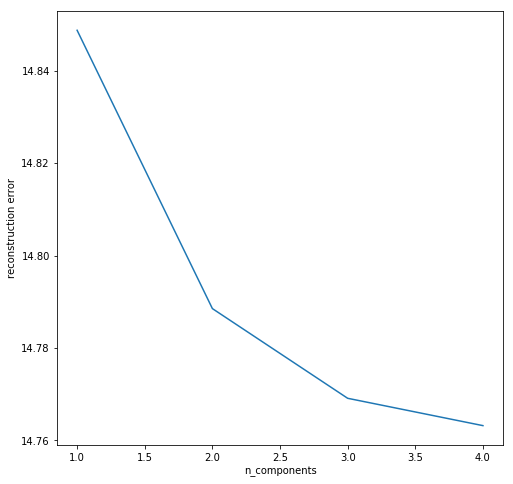

CPU times: user 214 ms, sys: 20.8 ms, total: 235 ms
Wall time: 155 ms


In [19]:
%%time

iris = datasets.load_iris()
X = iris.data
ns = [1, 2, 3, 4]
errors = []
for n in ns:
    pca = My_PCA(n)
    pca.fit(X)
    X_ = pca.transform(X)
    decompress_X = decompress(X_, pca.components)
    errors.append(reconstruction_error(X, decompress_X))

plt.figure(figsize=(8, 8))
plt.plot(ns, errors)
plt.xlabel('n_components')
plt.ylabel('reconstruction error')
plt.show()

# 3. Reference

[1] https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

[2] https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/decomposition/pca.py